<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/ML-Manuel/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFT

## Environment Setup

In [324]:
!git clone -b ML-Manuel https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 668 (delta 94), reused 25 (delta 25), pack-reused 517 (from 3)
Receiving objects: 100% (668/668), 68.35 MiB | 23.76 MiB/s, done.
Resolving deltas: 100% (347/347), done.
/content/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data


In [325]:
#!pip install pytorch-lightning
#!pip install pytorch-forecasting

## Import

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE
import os
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
from pytorch_forecasting.data.encoders import NaNLabelEncoder

In [327]:
# Extract and load the dataset
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

In [328]:
# Check if GPU is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

CUDA available: False
Using CPU


## Data Exploration

In [329]:
# Display basic info about the dataset
print(f"Original dataframe shape: {df.shape}")

print("\nFirst few rows:")
print(df.head())

print("\nUnique tickers:")
print(df['Ticker'].unique())
print(f"Number of unique tickers: {df['Ticker'].nunique()}")

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

Original dataframe shape: (8103, 817)

First few rows:
         Date       Open       High        Low      Close    Volume  \
0  2021-06-01  75.393341  75.630189  74.351213  75.383865  10485300   
1  2021-06-02  75.507015  76.672309  75.327016  76.047028  12249300   
2  2021-06-03  75.601763  77.174428  75.459653  76.823891  12038700   
3  2021-06-04  77.136525  79.542898  77.089160  78.529190  14502900   
4  2021-06-07  78.576573  79.817653  78.491304  79.523964  10445600   

   Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
0        0.0           0.0           23368.861                    5.9  ...   
1        0.0           0.0           23368.861                    5.9  ...   
2        0.0           0.0           23368.861                    5.9  ...   
3        0.0           0.0           23368.861                    5.9  ...   
4        0.0           0.0           23368.861                    5.9  ...   

   emb_763  emb_764  emb_765  emb_766  emb_767  T

## Data Preparation

In [330]:
# Remove lag features since TFT will handle time dependencies
lag_columns = [col for col in df.columns if '_lag' in col]
print(f"\nRemoving {len(lag_columns)} lag columns from the dataset")
df_no_lag = df.drop(columns=lag_columns)

# Handle embedding columns - Either keep them or use PCA to reduce dimensionality
# Identify embedding columns
emb_columns = [col for col in df_no_lag.columns if col.startswith('emb_')]
print(f"\nFound {len(emb_columns)} embedding columns")

# Option 1: Remove embedding columns since they might be too many for TFT
df_no_emb = df_no_lag.drop(columns=emb_columns)

# We'll work with the version without embeddings for simplicity
df_processed = df_no_emb


Removing 0 lag columns from the dataset

Found 768 embedding columns


In [331]:
# Select target and features for the model
target = 'Close'  # Or could be 'Close' , 'Target_1day', 'Target_1week', 'Target_1month', 'Target_1year'

# Select relevant features for prediction
# Exclude Date, target variables, and other non-predictive columns
exclude_columns = ['Date'] + [col for col in df_processed.columns if col.startswith('Target_')]
if target not in exclude_columns:
    exclude_columns.append(target)
features = [col for col in df_processed.columns if col not in exclude_columns]
print(f"\nUsing {len(features)} features for prediction")


Using 43 features for prediction


In [332]:
# Create time index for TFT
df_processed['time_idx'] = df_processed.groupby('Ticker')['Date'].rank(method='dense').astype(int) - 1

# Verify time_idx is properly set for each ticker
for ticker in df_processed['Ticker'].unique():
    ticker_data = df_processed[df_processed['Ticker'] == ticker]
    print(f"{ticker}: time_idx from {ticker_data['time_idx'].min()} to {ticker_data['time_idx'].max()}")

# Set parameters for prediction
# If predicting Target_1day, max_prediction_length=1
# If predicting Target_1week, max_prediction_length=5 (assuming 5 trading days)
# If predicting Target_1month, max_prediction_length=20
max_prediction_length = 1  # Adjust based on your prediction horizon
max_encoder_length = 30    # Use 30 days of history for prediction

ORCL: time_idx from 0 to 922
MSFT: time_idx from 0 to 901
AAPL: time_idx from 0 to 837
AVGO: time_idx from 0 to 815
AMD: time_idx from 0 to 773
AMZN: time_idx from 0 to 773
GOOGL: time_idx from 0 to 773
META: time_idx from 0 to 773
TSLA: time_idx from 0 to 773
NVDA: time_idx from 0 to 753


## Training Setup

In [333]:
# Create a training dataset - Use the last 20% of the data for testing
val_cutoff = df_processed['time_idx'].max() - max_prediction_length
cutoffs = {}
for ticker in df_processed['Ticker'].unique():
    ticker_data = df_processed[df_processed['Ticker'] == ticker]
    cutoffs[ticker] = ticker_data['time_idx'].max() * 0.8

df_processed['is_train'] = True
for ticker, cutoff in cutoffs.items():
    df_processed.loc[(df_processed['Ticker'] == ticker) &
                    (df_processed['time_idx'] > cutoff), 'is_train'] = False

In [334]:
# Check which columns have missing values
missing_columns = df_processed.isna().sum()
print("\nColumns with missing values:")
print(missing_columns[missing_columns > 0].sort_values(ascending=False))

# Check for infinite values
df_processed = df_processed.replace([np.inf, -np.inf], np.nan)

# Handle missing values in Inventory specifically (since that's causing the error)
if 'Inventory' in df_processed.columns:
    # For each ticker, fill missing Inventory values with median (or 0 if median is NaN)
    for ticker in df_processed['Ticker'].unique():
        ticker_mask = df_processed['Ticker'] == ticker
        ticker_inventory_median = df_processed.loc[ticker_mask, 'Inventory'].median()
        if pd.isna(ticker_inventory_median):
            ticker_inventory_median = 0
        df_processed.loc[ticker_mask, 'Inventory'] = df_processed.loc[ticker_mask, 'Inventory'].fillna(ticker_inventory_median)


Columns with missing values:
neutral                        5378
negative                       5378
vote                           5378
positive                       5378
Target_1year                   2500
Inventory                      1697
Repurchase Of Capital Stock     774
Long Term Debt                  252
Target_1month                   200
Target_1week                     50
Target_1day                      10
dtype: int64


In [335]:
# Check all features for missing values and fill appropriately
for feature in features:
    if df_processed[feature].isna().sum() > 0:
        print(f"Filling missing values in {feature}")
        # Fill by ticker
        for ticker in df_processed['Ticker'].unique():
            ticker_mask = df_processed['Ticker'] == ticker
            feature_median = df_processed.loc[ticker_mask, feature].median()
            if pd.isna(feature_median):  # If median is NaN (all values are NaN)
                feature_median = 0
            df_processed.loc[ticker_mask, feature] = df_processed.loc[ticker_mask, feature].fillna(feature_median)

# Verify all missing values are fixed
remaining_missing = df_processed[features].isna().sum()
if remaining_missing.sum() > 0:
    print("Warning: There are still missing values:")
    print(remaining_missing[remaining_missing > 0])
else:
    print("All missing values have been handled.")

Filling missing values in Long Term Debt
Filling missing values in Repurchase Of Capital Stock
Filling missing values in vote
Filling missing values in negative
Filling missing values in neutral
Filling missing values in positive
All missing values have been handled.


## Create TimeSeriesDataSets

In [336]:
# Reduced feature set for simplicity
reduced_features = features[:20]  # Use only the first 20 features to simplify

# Create training dataset
training = TimeSeriesDataSet(
    data=df_processed[df_processed['is_train']],
    time_idx="time_idx",
    target=target,
    group_ids=["Ticker"],
    min_encoder_length=15,  # Reduced from 30
    max_encoder_length=15,  # Reduced from 30
    min_prediction_length=1,
    max_prediction_length=1,
    static_categoricals=["Ticker"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=reduced_features,  # Use reduced feature set
    target_normalizer=GroupNormalizer(
        groups=["Ticker"], transformation="softplus"
    ),
    categorical_encoders={
        "Ticker": NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [337]:
# Verify there are no lag features in the data
print("Lag feature verification:")
lag_features = [col for col in df.columns if '_lag' in col]
print(f"Number of lag features in original dataframe: {len(lag_features)}")
if len(lag_features) == 0:
    print("No lag features found in dataframe. These will be handled by TFT automatically.")
else:
    print("Lag features found in dataframe. Consider removing them to let TFT handle temporal dependencies.")
    print(f"First few lag features: {lag_features[:5]}")

Lag feature verification:
Number of lag features in original dataframe: 0
No lag features found in dataframe. These will be handled by TFT automatically.


In [338]:
# Check ticker sequence organization
ticker_counts = df_processed.groupby('Ticker').size()
print("\nRows per ticker:")
print(ticker_counts)


Rows per ticker:
Ticker
AAPL     838
AMD      774
AMZN     774
AVGO     816
GOOGL    774
META     774
MSFT     902
NVDA     754
ORCL     923
TSLA     774
dtype: int64


In [339]:
# Check if there are enough data points per ticker for the encoder length
min_required = max_encoder_length + max_prediction_length
print(f"\nTickers with insufficient data (<{min_required} points):")
print(ticker_counts[ticker_counts < min_required])


Tickers with insufficient data (<31 points):
Series([], dtype: int64)


In [340]:
# Show time index consistency by ticker
print("\nTime index range by ticker:")
for ticker in df_processed['Ticker'].unique():
    ticker_data = df_processed[df_processed['Ticker'] == ticker]
    print(f"{ticker}: {ticker_data['time_idx'].min()} to {ticker_data['time_idx'].max()} ({len(ticker_data)} rows)")


Time index range by ticker:
ORCL: 0 to 922 (923 rows)
MSFT: 0 to 901 (902 rows)
AAPL: 0 to 837 (838 rows)
AVGO: 0 to 815 (816 rows)
AMD: 0 to 773 (774 rows)
AMZN: 0 to 773 (774 rows)
GOOGL: 0 to 773 (774 rows)
META: 0 to 773 (774 rows)
TSLA: 0 to 773 (774 rows)
NVDA: 0 to 753 (754 rows)


In [341]:
# Handle NaN values in target columns
print(f"Number of rows with NA in {target}: {df_processed[target].isna().sum()}")
df_processed[target] = df_processed[target].fillna(0)  # Fill with 0 or another appropriate value
print(f"NAs remaining in {target}: {df_processed[target].isna().sum()}")

Number of rows with NA in Close: 0
NAs remaining in Close: 0


In [342]:
# Create validation dataset and dataloaders
validation = TimeSeriesDataSet.from_dataset(
    training, df_processed[~df_processed['is_train']], predict=True, stop_randomization=True
)

In [343]:
# Create dataloaders for model training
batch_size = 32  # Adjust based on  GPU memory
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)

## Model Training

In [344]:
pl.seed_everything(42)  # For reproducibility

# Create the TFT model properly as a LightningModule
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=5,
)

# Confirm it's a LightningModule
print(f"Is LightningModule: {isinstance(tft, pl.LightningModule)}")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Is LightningModule: True


In [345]:
# Configure trainer
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = pl.callbacks.LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=30,
    accelerator='auto',  # Use GPU if available
    gradient_clip_val=0.1,
    limit_train_batches=30,  # Adjust based on dataset size
    callbacks=[early_stop_callback, lr_logger],
)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [346]:
# Train the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 66     | train
3  | prescalers                         | ModuleDict                      | 400    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.8 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Model Evaluation and Prediction

In [347]:
# Make predictions on the validation set
predictions = tft.predict(val_dataloader, return_y=True)

# Extract raw predictions and actual values
raw_predictions = predictions.output.detach().cpu().numpy()
raw_actuals = predictions.y[0].detach().cpu().numpy()

# Convert predictions to dataframe for easier analysis
pred_df = pd.DataFrame({
    'prediction': raw_predictions.flatten(),
    'actual': raw_actuals.flatten()
})

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [348]:
# Calculate metrics
mae = mean_absolute_error(pred_df['actual'], pred_df['prediction'])
mse = mean_squared_error(pred_df['actual'], pred_df['prediction'])
rmse = np.sqrt(mse)
r2 = r2_score(pred_df['actual'], pred_df['prediction'])

print("\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Model Performance:
MAE: 154.5705
MSE: 46652.1133
RMSE: 215.9910
R²: -0.6774


## Visualization

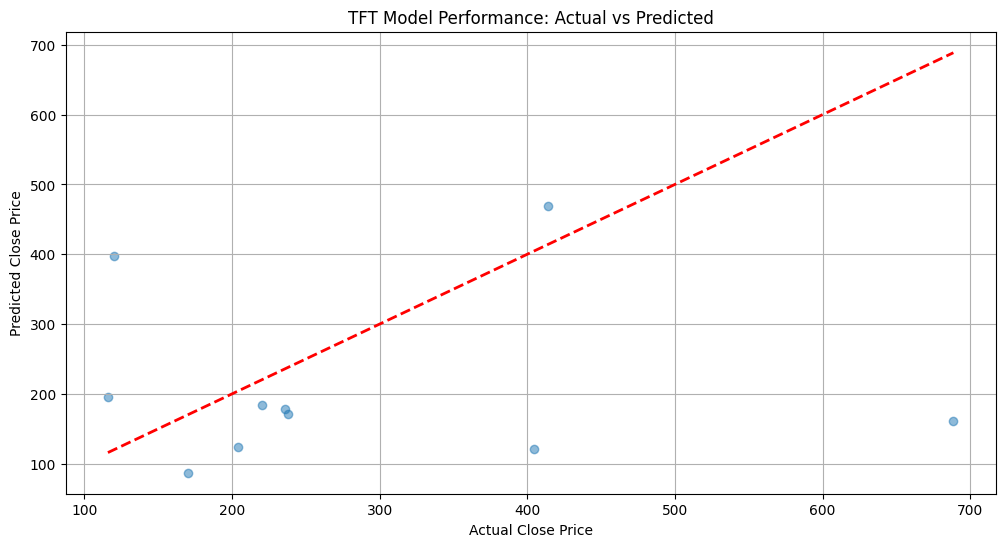

In [315]:
# Visualize predictions vs actuals
plt.figure(figsize=(12, 6))
plt.scatter(pred_df['actual'], pred_df['prediction'], alpha=0.5)
plt.plot([pred_df['actual'].min(), pred_df['actual'].max()],
       [pred_df['actual'].min(), pred_df['actual'].max()],
       'r--', lw=2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('TFT Model Performance: Actual vs Predicted')
plt.grid(True)
plt.savefig('tft_performance.png')
plt.show()

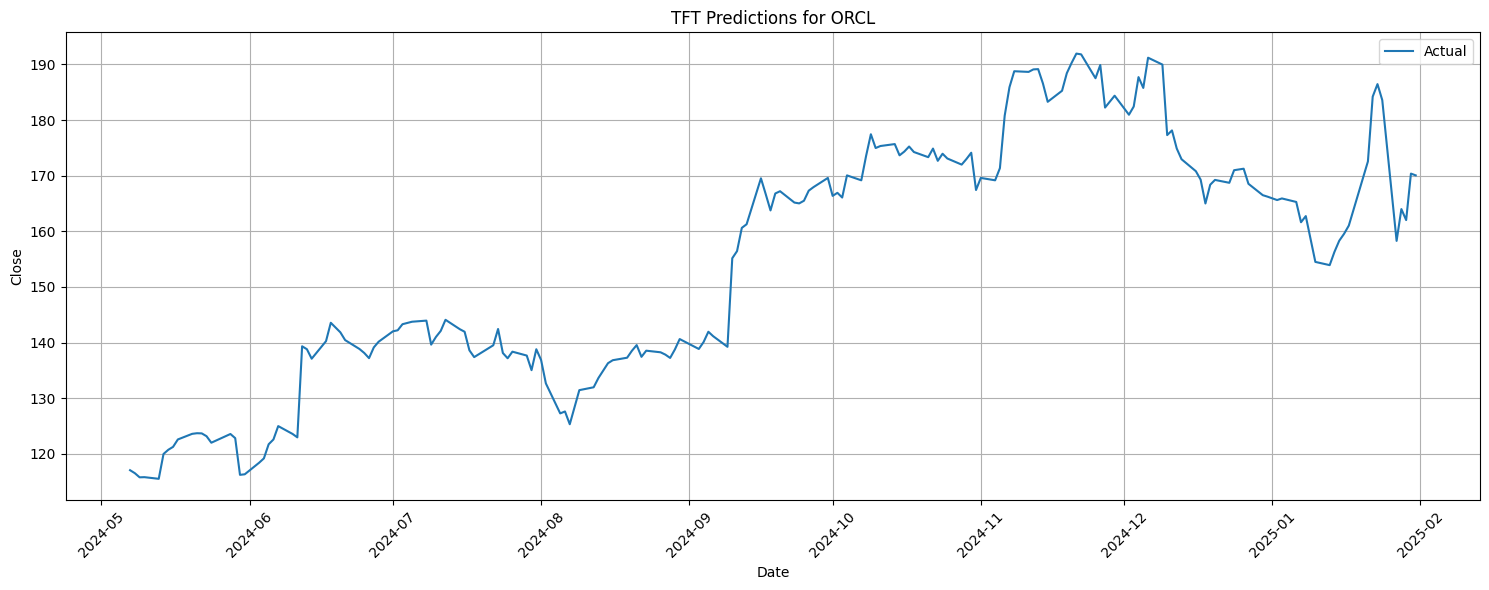

In [316]:
# Visualize predictions vs actuals over time for a specific stock
ticker_to_plot = df_processed['Ticker'].unique()[0]  # Choose first ticker
ticker_val_data = df_processed[(df_processed['Ticker'] == ticker_to_plot) & (~df_processed['is_train'])].copy()

# Plot time series data for the selected ticker
if len(ticker_val_data) > 0:
    plt.figure(figsize=(15, 6))
    plt.plot(ticker_val_data['Date'], ticker_val_data[target], label='Actual')
    # You would add predictions here after matching them to dates
    plt.title(f'TFT Predictions for {ticker_to_plot}')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'tft_predictions_{ticker_to_plot}.png')
    plt.show()

## Feature Importance

In [319]:
# Get feature importance from the TFT model
importances = tft.interpret_output(val_dataloaders, reduction="mean")

NameError: name 'val_dataloaders' is not defined

In [321]:
# Variable importance
plt.figure(figsize=(10, 8))
order = importances.mean(dim=["variable", "observation"]).argsort(descending=True)
plt.imshow(importances.mean(dim="observation").index_select(0, order), aspect="auto")
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.colorbar()
plt.savefig('tft_feature_importance.png')
plt.show()

AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 1000x800 with 0 Axes>

## Saving Model

In [320]:
# Save the trained model

torch.save(tft.state_dict(), "tft_stock_model.pth")
print("\nModel training and evaluation complete. Check the output directory for visualization plots.")


Model training and evaluation complete. Check the output directory for visualization plots.
